In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [29]:
num_qubits_head = 7  # 7 qubit per il primo circuito
num_qubits_tail = 6  # 6 qubit per il secondo circuito
n_a_qubits = 1  # 1 qubit ancilla

device1 = qml.device("default.qubit", wires=num_qubits_head)
device2 = qml.device("default.qubit", wires=num_qubits_tail)

@qml.qnode(device1)
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_head))
    return qml.probs(wires=range(num_qubits_head))

@qml.qnode(device2)
def quantum_circuit1(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_tail))
    return qml.probs(wires=range(num_qubits_tail))

class QuantumDenoiser(nn.Module):
    def __init__(self, n_layers=10):
        super().__init__()
        self.n_qubits = num_qubits_head
        self.n_qubits1 = num_qubits_tail
        self.n_a_qubits = n_a_qubits
        
        weight_shapes = {"weights": (n_layers, num_qubits_head, 3)}
        weight_shapes1 = {"weights": (n_layers, num_qubits_tail, 3)}
        
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.qlayer1 = qml.qnn.TorchLayer(quantum_circuit1, weight_shapes1)

    def forward(self, x):
        probs = self.qlayer(x.unsqueeze(0))
        probsgiven0 = probs[:, : (2 ** (self.n_qubits - self.n_a_qubits))]
        probsgiven0 /= torch.sum(probs)
        return self.qlayer1(probsgiven0)

In [30]:
num_qubits = 6
dev = qml.device("default.mixed", wires=num_qubits)

@qml.qnode(dev)
def mnist_to_quantum_state(image_vector, noise_param):
    qml.AmplitudeEmbedding(image_vector, wires=range(num_qubits), normalize=True)
    for i in range(num_qubits):
        qml.DepolarizingChannel(noise_param, wires=i)
    return qml.state()

def reconstruct_image(density_matrix):
    amplitudes = np.sqrt(np.real(np.diag(density_matrix)))
    amplitudes = amplitudes / np.linalg.norm(amplitudes)
    return amplitudes.reshape(8, 8)

# Carica e prepara l'immagine MNIST
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((8, 8)),
    torchvision.transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
index = 0
image, label = mnist_dataset[index]
image_flat = image.numpy().flatten()
image_normalized = image_flat / np.linalg.norm(image_flat)

Step: 1, Noise: 0.025, Purity: 0.762425
Step: 2, Noise: 0.050, Purity: 0.581240
Step: 3, Noise: 0.075, Purity: 0.443485
Step: 4, Noise: 0.100, Purity: 0.339038
Step: 5, Noise: 0.125, Purity: 0.260037
Step: 6, Noise: 0.150, Purity: 0.200399
Step: 7, Noise: 0.175, Purity: 0.155444
Step: 8, Noise: 0.200, Purity: 0.121585
Step: 9, Noise: 0.225, Purity: 0.096088
Step: 10, Noise: 0.250, Purity: 0.076877
Step: 11, Noise: 0.275, Purity: 0.062383
Step: 12, Noise: 0.300, Purity: 0.051424
Step: 13, Noise: 0.325, Purity: 0.043112
Step: 14, Noise: 0.350, Purity: 0.036784
Step: 15, Noise: 0.375, Purity: 0.031945
Step: 16, Noise: 0.400, Purity: 0.028225
Step: 17, Noise: 0.425, Purity: 0.025351
Step: 18, Noise: 0.450, Purity: 0.023117
Step: 19, Noise: 0.475, Purity: 0.021371
Step: 20, Noise: 0.500, Purity: 0.020000
Step: 21, Noise: 0.525, Purity: 0.018920
Step: 22, Noise: 0.550, Purity: 0.018067
Step: 23, Noise: 0.575, Purity: 0.017393
Step: 24, Noise: 0.600, Purity: 0.016864
Step: 25, Noise: 0.625, P

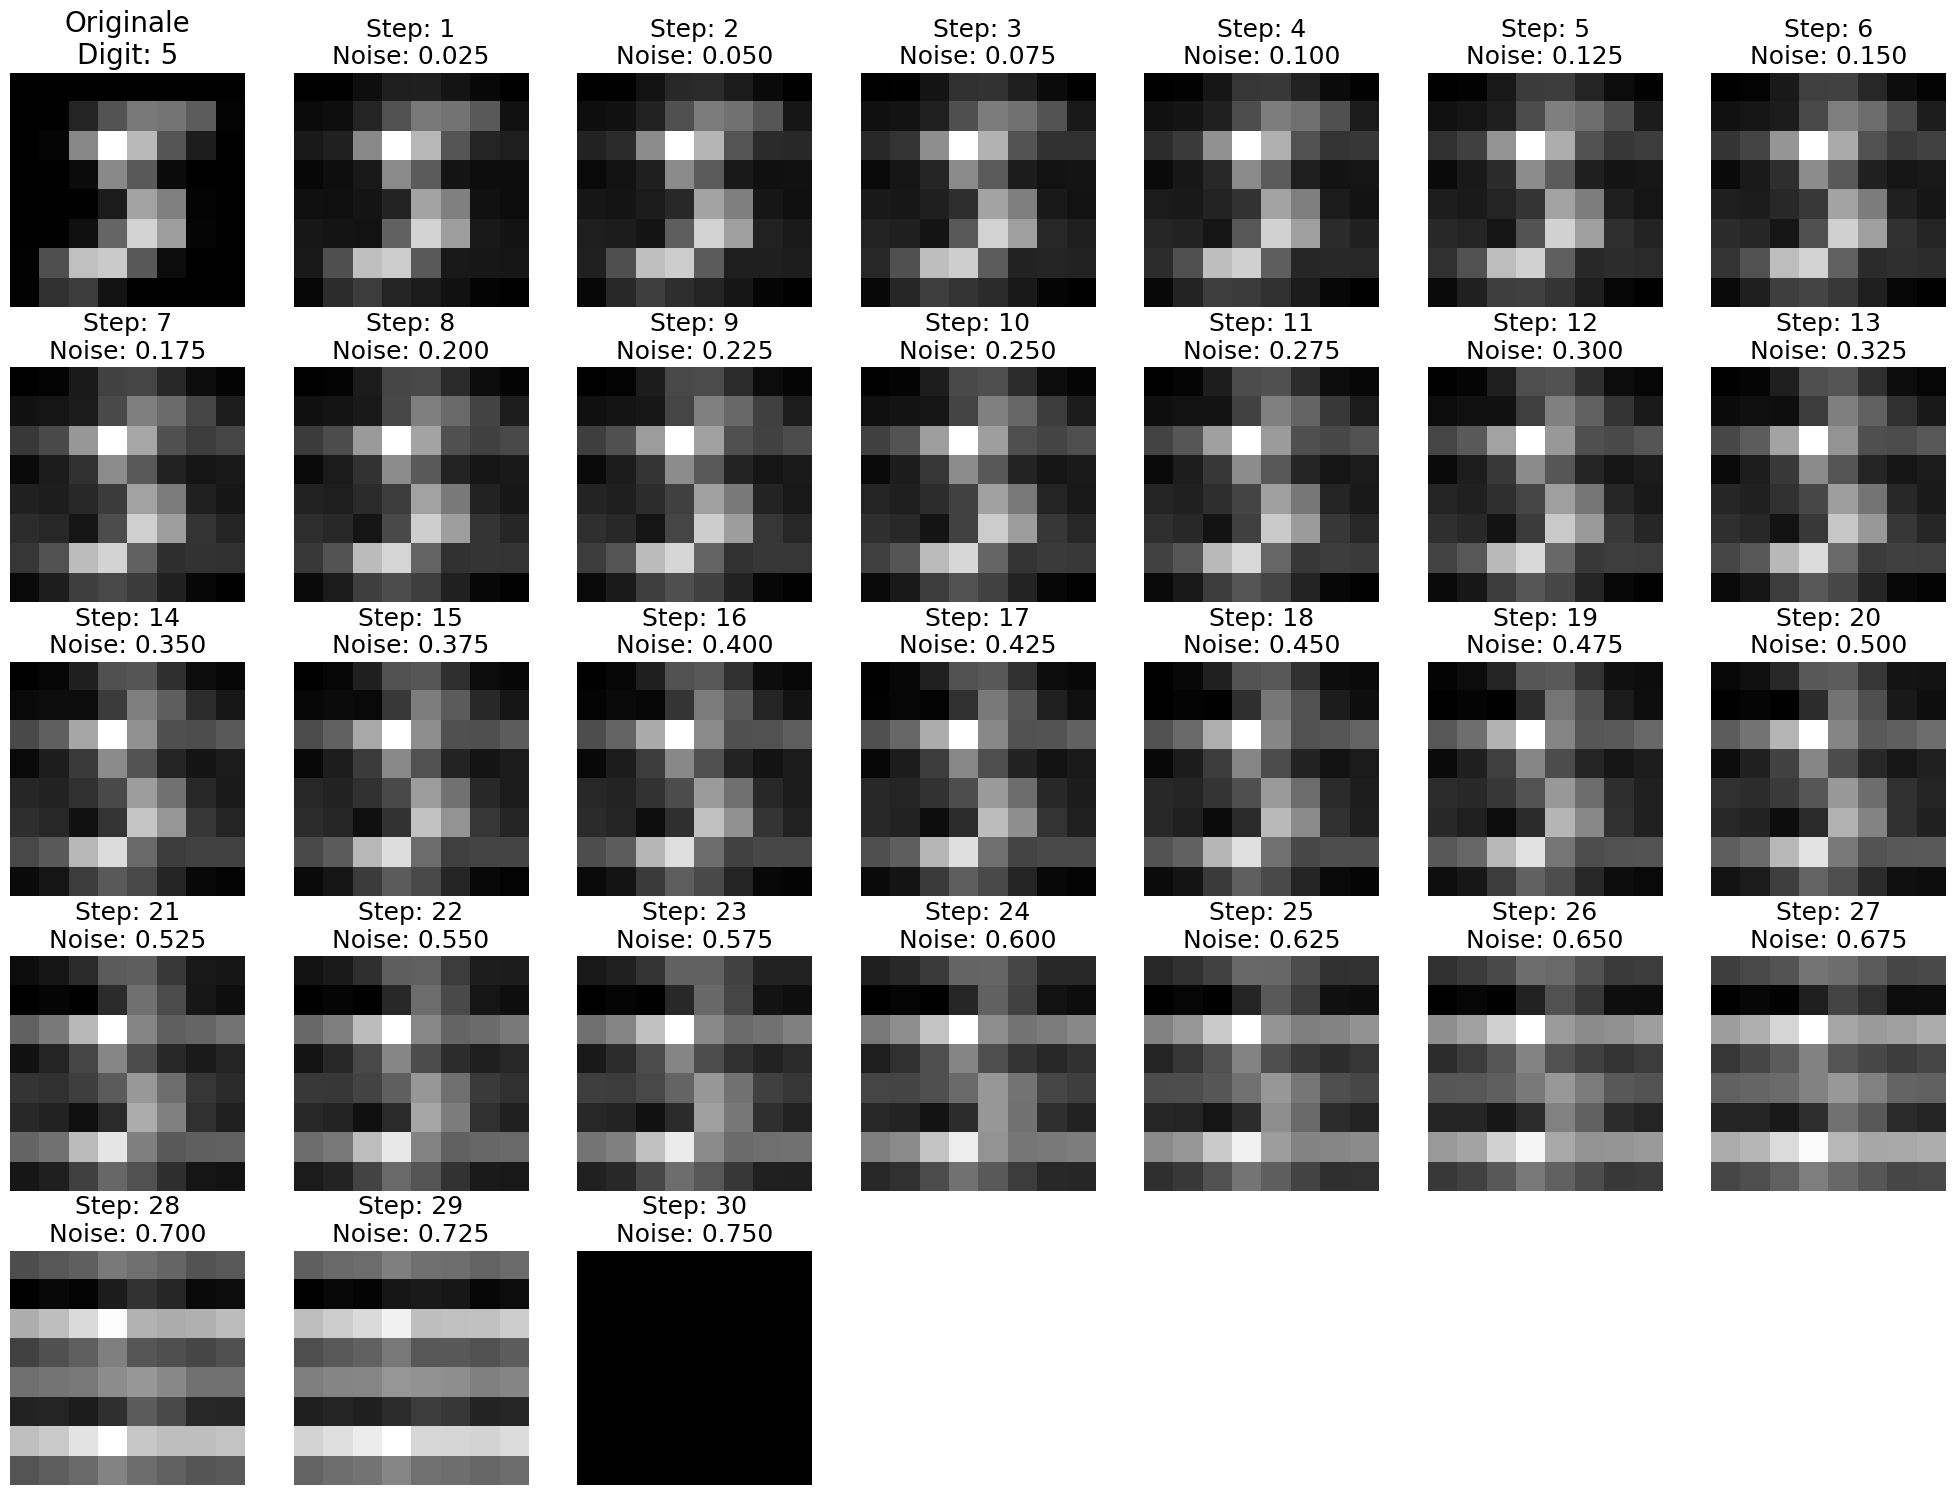

In [31]:
import matplotlib.pyplot as plt
import numpy as np

total_steps = 30
max_noise = 0.75

num_rows = 5
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Converti il tensore in un array numpy e in float32
image_np = image.squeeze().cpu().numpy().astype(np.float32)

# Visualizza l'immagine originale
axes[0, 0].imshow(image_np, cmap='gray')
axes[0, 0].set_title(f"Originale\nDigit: {label}", fontsize=20)  # Font più grande
axes[0, 0].axis('off')
depolarized_images = []

# Applica il rumore gradualmente e visualizza i risultati
for step in range(total_steps):
    current_noise = max_noise * (step + 1) / total_steps
    density_matrix = mnist_to_quantum_state(image_normalized, current_noise)
    depolarized_image = reconstruct_image(density_matrix).astype(np.float32)  # Converti a float32
    depolarized_images.append(depolarized_image)
    row = (step + 1) // num_cols
    col = (step + 1) % num_cols
    axes[row, col].imshow(depolarized_image, cmap='gray')
    axes[row, col].set_title(f"Step: {step+1}\nNoise: {current_noise:.3f}", fontsize=18)  # Font più grande
    axes[row, col].axis('off')
    
    purity = np.real(np.trace(np.matmul(density_matrix, density_matrix)))
    print(f"Step: {step+1}, Noise: {current_noise:.3f}, Purity: {purity:.6f}")

# Rimuovi gli assi vuoti
for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j >= total_steps + 1:
            fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

In [32]:
model = QuantumDenoiser(n_layers=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    noisy_image = torch.tensor(depolarized_images[total_steps - 1].flatten())
    for step in range(total_steps - 1, 0, -1):
        target_image = torch.tensor(depolarized_images[step - 1].flatten())
        optimizer.zero_grad()
        denoised_image = model(noisy_image)
        loss = loss_fn(denoised_image.flatten(), target_image.flatten())
        loss.backward()
        optimizer.step()
        noisy_image = denoised_image.detach().flatten()
        total_loss += loss.item()
    
    avg_loss = total_loss / total_steps
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 0.011702
Epoch 2, Average Loss: 0.011460
Epoch 3, Average Loss: 0.011364
Epoch 4, Average Loss: 0.011182
Epoch 5, Average Loss: 0.011107
Epoch 6, Average Loss: 0.011036
Epoch 7, Average Loss: 0.010992
Epoch 8, Average Loss: 0.010984
Epoch 9, Average Loss: 0.010950
Epoch 10, Average Loss: 0.010940
Epoch 11, Average Loss: 0.010931
Epoch 12, Average Loss: 0.010908
Epoch 13, Average Loss: 0.010919
Epoch 14, Average Loss: 0.010896
Epoch 15, Average Loss: 0.010902
Epoch 16, Average Loss: 0.010876
Epoch 17, Average Loss: 0.010883
Epoch 18, Average Loss: 0.010841
Epoch 19, Average Loss: 0.010866
Epoch 20, Average Loss: 0.010794
Epoch 21, Average Loss: 0.010970
Epoch 22, Average Loss: 0.010941
Epoch 23, Average Loss: 0.010920
Epoch 24, Average Loss: 0.010868
Epoch 25, Average Loss: 0.010910
Epoch 26, Average Loss: 0.010825
Epoch 27, Average Loss: 0.010857
Epoch 28, Average Loss: 0.010804
Epoch 29, Average Loss: 0.010802
Epoch 30, Average Loss: 0.010785
Epoch 31, Average L

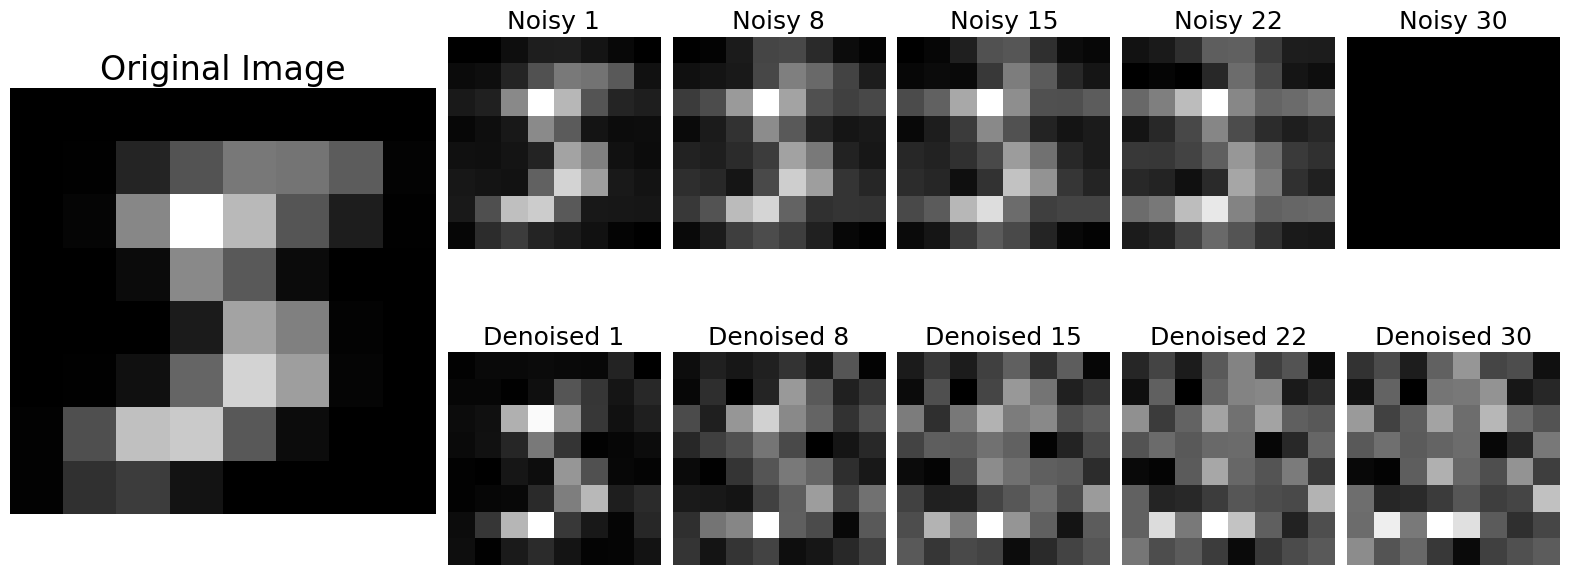

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Definiamo un sottoinsieme distribuito uniformemente di timesteps
subset_timesteps = np.linspace(0, total_steps - 1, num=5, dtype=int)  # 5 timesteps distribuiti

# Creiamo un layout con l'immagine originale a sinistra e le altre a destra
fig = plt.figure(figsize=(20, 8))  # Aumentiamo le dimensioni complessive della figura
gs = fig.add_gridspec(2, len(subset_timesteps) + 1, width_ratios=[2] + [1]*len(subset_timesteps))

# Immagine originale
ax_original = fig.add_subplot(gs[:, 0])
ax_original.imshow(image.squeeze(), cmap='gray')
ax_original.set_title("Original Image", fontsize=24)  # Font più grande
ax_original.axis('off')

# Immagini rumorose e denoisate
for i, step in enumerate(subset_timesteps):
    # Immagine rumorosa
    ax_noisy = fig.add_subplot(gs[0, i + 1])
    ax_noisy.imshow(np.abs(depolarized_images[step]), cmap='gray')
    ax_noisy.set_title(f"Noisy {step+1}", fontsize=18)  # Font molto più grande
    ax_noisy.axis('off')

    # Immagine denoised
    ax_denoised = fig.add_subplot(gs[1, i + 1])
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[step].flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image).numpy().reshape(8, 8)
    ax_denoised.imshow(denoised_image, cmap='gray')
    ax_denoised.set_title(f"Denoised {step+1}", fontsize=18)  # Font molto più grande
    ax_denoised.axis('off')

# Eliminiamo tutto lo spazio bianco tra le immagini
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Riduciamo lo spazio al minimo
plt.margins(0)  # Elimina i margini

# Mostra la figura finale senza titolo e senza spazio bianco
plt.show()

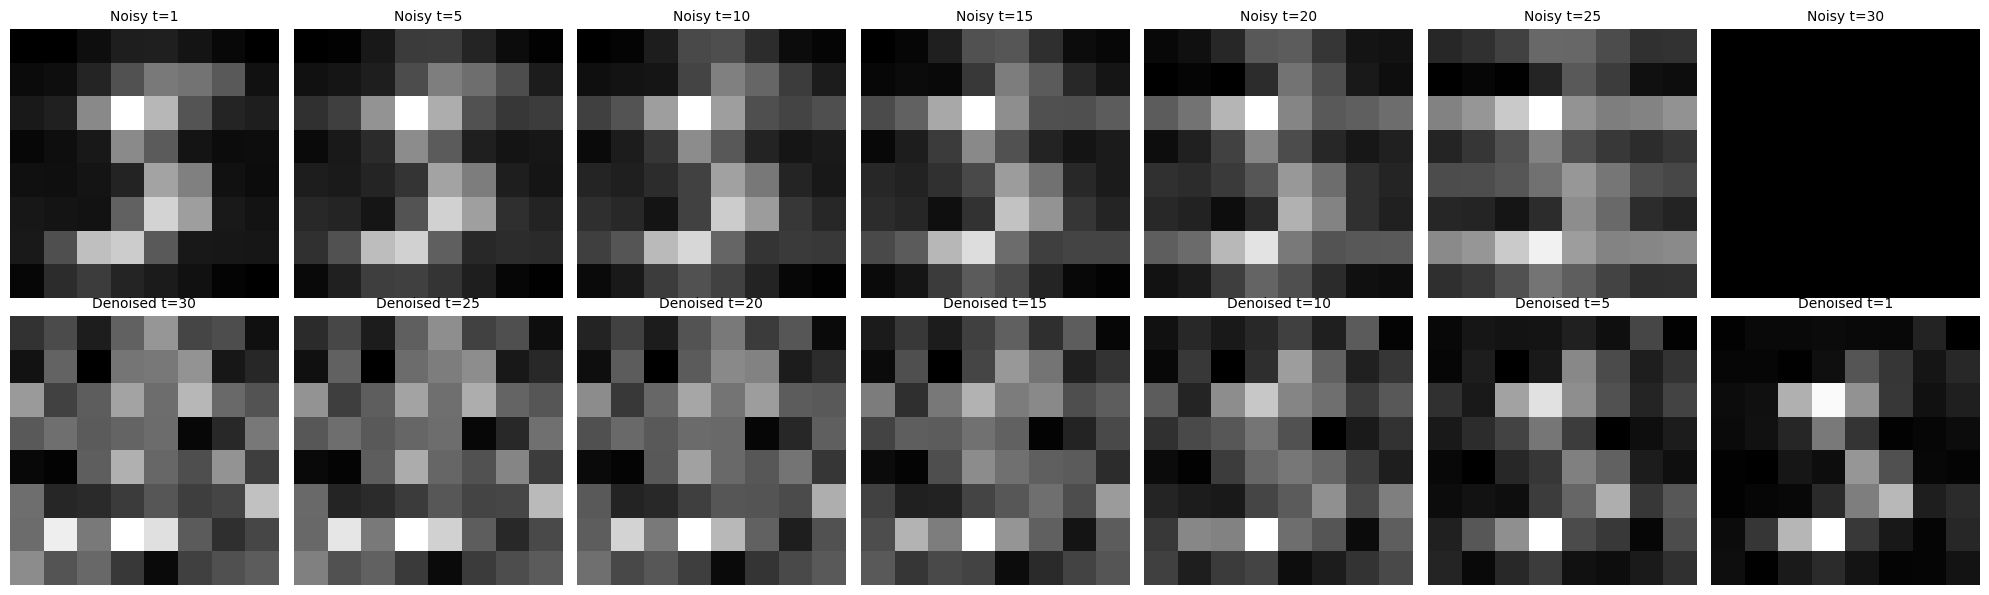

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Timestep specifici per le immagini rumorose e denoisate
noisy_timesteps = [1, 5, 10, 15, 20, 25, 30]
denoised_timesteps = [30, 25, 20, 15, 10, 5, 1]

# Creiamo un layout per le immagini rumorose e denoisate
fig, axs = plt.subplots(2, 7, figsize=(20, 6))

# Immagini rumorose e denoisate
for i, (noisy_step, denoised_step) in enumerate(zip(noisy_timesteps, denoised_timesteps)):
    # Immagine rumorosa
    axs[0, i].imshow(np.abs(depolarized_images[noisy_step - 1]), cmap='gray')
    axs[0, i].set_title(f"Noisy t={noisy_step}", fontsize=10)
    axs[0, i].axis('off')

    # Immagine denoised
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[denoised_step - 1].flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image).numpy().reshape(8, 8)
    axs[1, i].imshow(denoised_image, cmap='gray')
    axs[1, i].set_title(f"Denoised t={denoised_step}", fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [35]:
def calculate_fidelity(state1, state2):
   state1 = qml.math.dm_from_state_vector(state1)
   state2 = qml.math.dm_from_state_vector(state2)
   return qml.math.fidelity(state1, state2)

# Calcola e stampa la fidelity tra l'immagine originale e quella denoised per ogni step
original_state = torch.tensor(image_normalized.flatten(), dtype=torch.complex64)
original_state = original_state / torch.norm(original_state)

for step in range(total_steps):
    with torch.no_grad():
        noisy_image = torch.tensor(np.abs(depolarized_images[step]).flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image)
        # Converti a complesso per il calcolo della fidelity
        denoised_state = denoised_image.to(torch.complex64)
        denoised_state = denoised_state / torch.norm(denoised_state)
    fidelity = calculate_fidelity(denoised_state.flatten(), original_state)
    print(f"Step {step+1}, Fidelity: {fidelity:.6f}")

Step 1, Fidelity: 0.866883
Step 2, Fidelity: 0.851752
Step 3, Fidelity: 0.830775
Step 4, Fidelity: 0.806462
Step 5, Fidelity: 0.780236
Step 6, Fidelity: 0.753079
Step 7, Fidelity: 0.725706
Step 8, Fidelity: 0.698646
Step 9, Fidelity: 0.672293
Step 10, Fidelity: 0.646928
Step 11, Fidelity: 0.622753
Step 12, Fidelity: 0.599906
Step 13, Fidelity: 0.578471
Step 14, Fidelity: 0.558495
Step 15, Fidelity: 0.539992
Step 16, Fidelity: 0.522952
Step 17, Fidelity: 0.507346
Step 18, Fidelity: 0.493132
Step 19, Fidelity: 0.480258
Step 20, Fidelity: 0.468666
Step 21, Fidelity: 0.458297
Step 22, Fidelity: 0.449088
Step 23, Fidelity: 0.440984
Step 24, Fidelity: 0.433929
Step 25, Fidelity: 0.427875
Step 26, Fidelity: 0.422780
Step 27, Fidelity: 0.418608
Step 28, Fidelity: 0.415332
Step 29, Fidelity: 0.412929
Step 30, Fidelity: 0.411384


In [37]:
class ClassicalDenoiser(nn.Module):
    def __init__(self, input_size=64, hidden_size=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        return self.model(x)

# Inizializzazione del modello e dell'ottimizzatore
model = ClassicalDenoiser()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Assumiamo che depolarized_images e image_normalized siano già definiti
total_steps = len(depolarized_images)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    noisy_image = torch.tensor(depolarized_images[total_steps - 1]).flatten()
    for step in range(total_steps - 1, 0, -1):
        target_image = torch.tensor(depolarized_images[step - 1]).flatten()
        optimizer.zero_grad()
        denoised_image = model(noisy_image)
        loss = loss_fn(denoised_image.flatten(), target_image)
        loss.backward()
        optimizer.step()
        noisy_image = denoised_image.detach().flatten()
        total_loss += loss.item()
    
    avg_loss = total_loss / total_steps
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 0.015462
Epoch 2, Average Loss: 0.005110
Epoch 3, Average Loss: 0.001428
Epoch 4, Average Loss: 0.001099
Epoch 5, Average Loss: 0.001081
Epoch 6, Average Loss: 0.001055
Epoch 7, Average Loss: 0.001040
Epoch 8, Average Loss: 0.001029
Epoch 9, Average Loss: 0.001021
Epoch 10, Average Loss: 0.001016
Epoch 11, Average Loss: 0.001016
Epoch 12, Average Loss: 0.001023
Epoch 13, Average Loss: 0.001028
Epoch 14, Average Loss: 0.001022
Epoch 15, Average Loss: 0.001009
Epoch 16, Average Loss: 0.000999
Epoch 17, Average Loss: 0.000994
Epoch 18, Average Loss: 0.000992
Epoch 19, Average Loss: 0.000992
Epoch 20, Average Loss: 0.000993
Epoch 21, Average Loss: 0.000997
Epoch 22, Average Loss: 0.000988
Epoch 23, Average Loss: 0.000988
Epoch 24, Average Loss: 0.000986
Epoch 25, Average Loss: 0.000983
Epoch 26, Average Loss: 0.000981
Epoch 27, Average Loss: 0.000978
Epoch 28, Average Loss: 0.000976
Epoch 29, Average Loss: 0.000973
Epoch 30, Average Loss: 0.000971
Epoch 31, Average L

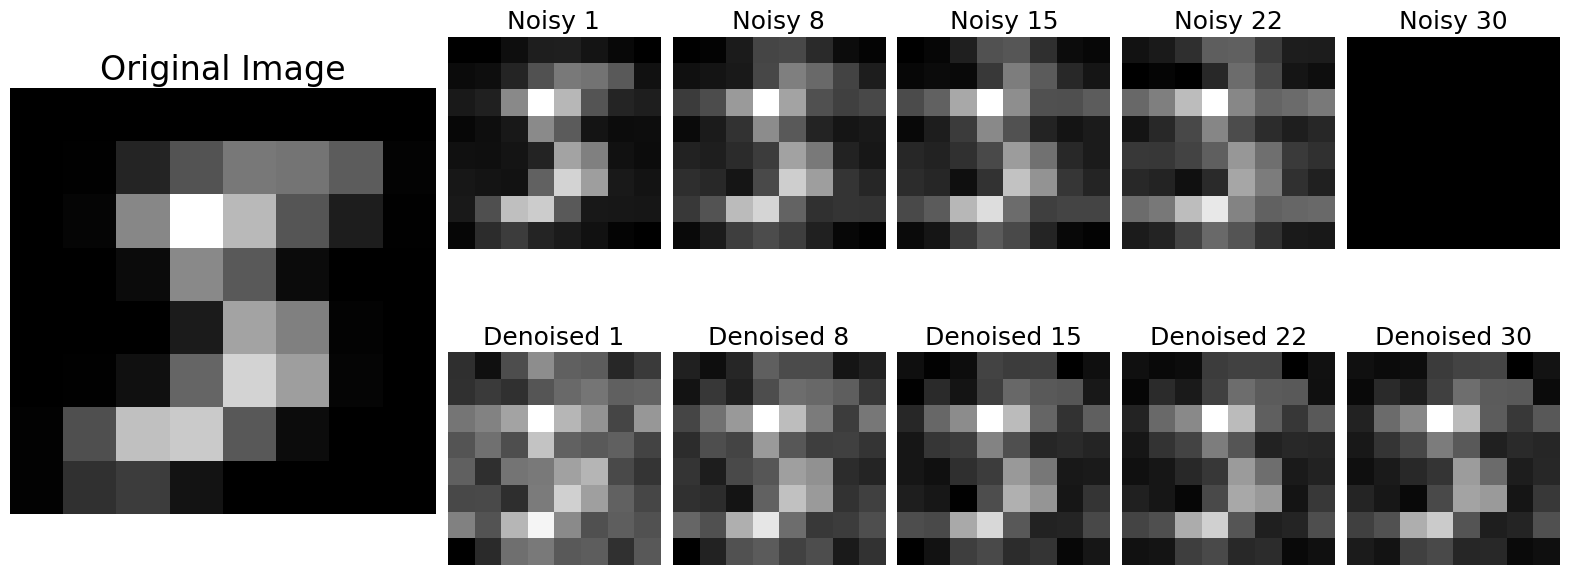

In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Definiamo un sottoinsieme distribuito uniformemente di timesteps
subset_timesteps = np.linspace(0, total_steps - 1, num=5, dtype=int)  # 5 timesteps distribuiti

# Creiamo un layout con l'immagine originale a sinistra e le altre a destra
fig = plt.figure(figsize=(20, 8))  # Aumentiamo le dimensioni complessive della figura
gs = fig.add_gridspec(2, len(subset_timesteps) + 1, width_ratios=[2] + [1]*len(subset_timesteps))

# Immagine originale
ax_original = fig.add_subplot(gs[:, 0])
ax_original.imshow(image.squeeze(), cmap='gray')
ax_original.set_title("Original Image", fontsize=24)  # Font più grande
ax_original.axis('off')

# Immagini rumorose e denoisate
for i, step in enumerate(subset_timesteps):
    # Immagine rumorosa
    ax_noisy = fig.add_subplot(gs[0, i + 1])
    ax_noisy.imshow(np.abs(depolarized_images[step]), cmap='gray')
    ax_noisy.set_title(f"Noisy {step+1}", fontsize=18)  # Font molto più grande
    ax_noisy.axis('off')

    # Immagine denoised
    ax_denoised = fig.add_subplot(gs[1, i + 1])
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[step].flatten())
        denoised_image = model(noisy_image).numpy().reshape(8, 8)
    ax_denoised.imshow(denoised_image, cmap='gray')
    ax_denoised.set_title(f"Denoised {step+1}", fontsize=18)  # Font molto più grande
    ax_denoised.axis('off')

# Eliminiamo tutto lo spazio bianco tra le immagini
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Riduciamo lo spazio al minimo
plt.margins(0)  # Elimina i margini

# Mostra la figura finale senza titolo e senza spazio bianco
plt.show()

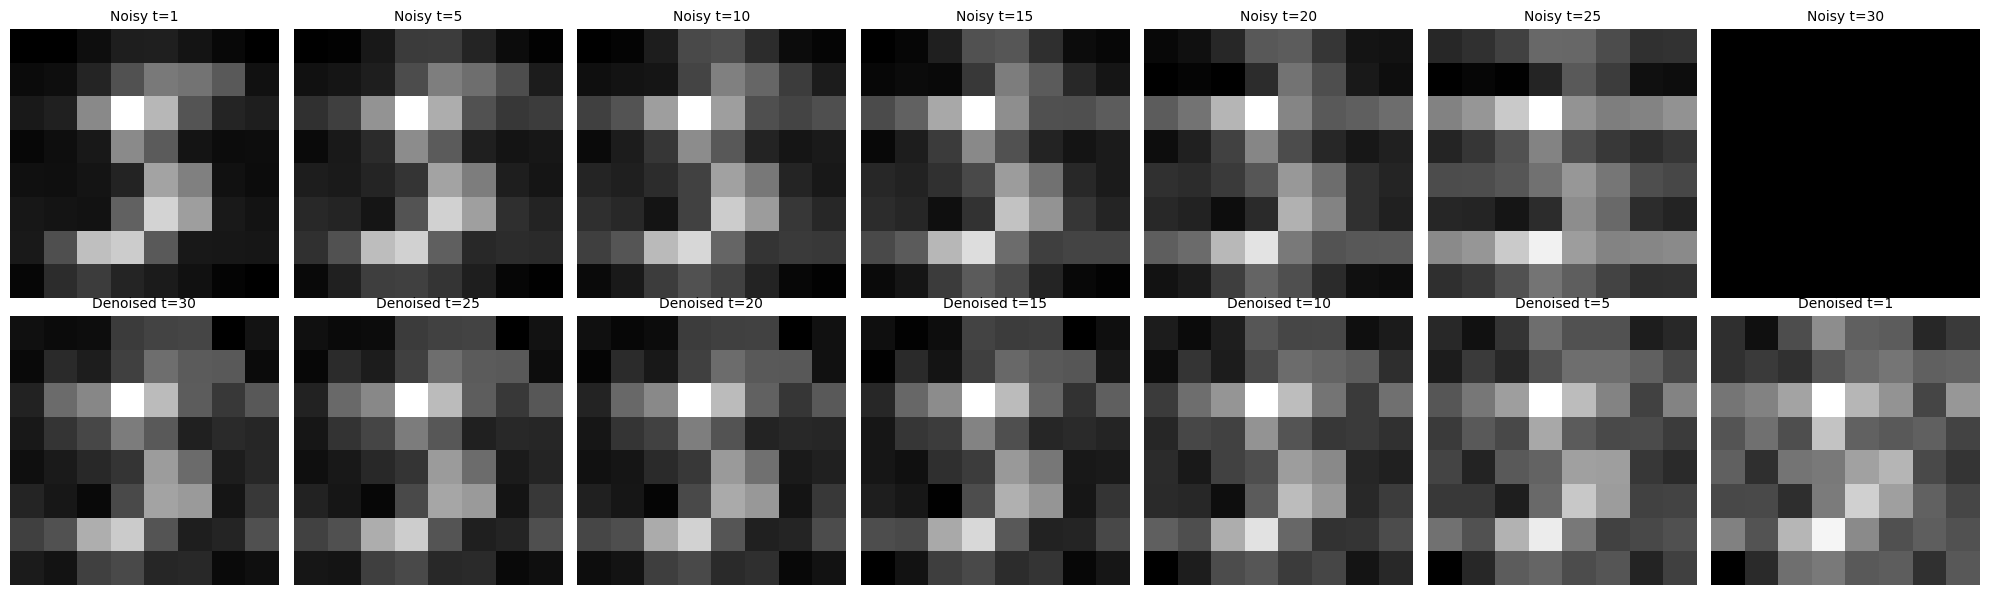

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Timestep specifici per le immagini rumorose e denoisate
noisy_timesteps = [1, 5, 10, 15, 20, 25, 30]
denoised_timesteps = [30, 25, 20, 15, 10, 5, 1]

# Creiamo un layout per le immagini rumorose e denoisate
fig, axs = plt.subplots(2, 7, figsize=(20, 6))

# Immagini rumorose e denoisate
for i, (noisy_step, denoised_step) in enumerate(zip(noisy_timesteps, denoised_timesteps)):
    # Immagine rumorosa
    axs[0, i].imshow(np.abs(depolarized_images[noisy_step - 1]), cmap='gray')
    axs[0, i].set_title(f"Noisy t={noisy_step}", fontsize=10)
    axs[0, i].axis('off')

    # Immagine denoised
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[denoised_step - 1].flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image).numpy().reshape(8, 8)
    axs[1, i].imshow(denoised_image, cmap='gray')
    axs[1, i].set_title(f"Denoised t={denoised_step}", fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [40]:
# Calcola e stampa la fidelity tra l'immagine originale e quella denoised per ogni step
original_state = torch.tensor(image_normalized.flatten(), dtype=torch.float32)
original_state = original_state / torch.norm(original_state)

for step in range(total_steps):
    with torch.no_grad():
        noisy_image = torch.tensor(np.abs(depolarized_images[step]).flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image)
        denoised_state = denoised_image / torch.norm(denoised_image)
    fidelity = calculate_fidelity(denoised_state, original_state)
    print(f"Step {step+1}, Fidelity: {fidelity:.6f}")

Step 1, Fidelity: 0.546948
Step 2, Fidelity: 0.552999
Step 3, Fidelity: 0.557172
Step 4, Fidelity: 0.560357
Step 5, Fidelity: 0.562919
Step 6, Fidelity: 0.565034
Step 7, Fidelity: 0.566881
Step 8, Fidelity: 0.568467
Step 9, Fidelity: 0.569830
Step 10, Fidelity: 0.571007
Step 11, Fidelity: 0.572023
Step 12, Fidelity: 0.572898
Step 13, Fidelity: 0.573649
Step 14, Fidelity: 0.574291
Step 15, Fidelity: 0.574833
Step 16, Fidelity: 0.575288
Step 17, Fidelity: 0.575663
Step 18, Fidelity: 0.575968
Step 19, Fidelity: 0.576212
Step 20, Fidelity: 0.576402
Step 21, Fidelity: 0.576545
Step 22, Fidelity: 0.576651
Step 23, Fidelity: 0.576725
Step 24, Fidelity: 0.576775
Step 25, Fidelity: 0.576807
Step 26, Fidelity: 0.576827
Step 27, Fidelity: 0.576839
Step 28, Fidelity: 0.576850
Step 29, Fidelity: 0.576860
Step 30, Fidelity: 0.576874
